In [238]:
# Import Python libraries that will be used in data processing

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, cross_validate, KFold

In [273]:
dataset = pd.read_csv("Student_Performance.csv")
dataset.head()

,Hours_Studied,Previous_Scores,Extracurricular_Activities,Sleep_Hours,Papers_Practiced,Performance_Index
0,7,99,Yes,9,1,91
1,4,82,No,4,2,65
2,8,51,Yes,7,2,45
3,5,52,Yes,5,2,36
4,7,75,No,8,5,66


In [264]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               10000 non-null  int64 
 1   Previous_Scores             10000 non-null  int64 
 2   Extracurricular_Activities  10000 non-null  object
 3   Sleep_Hours                 10000 non-null  int64 
 4   Papers_Practiced            10000 non-null  int64 
 5   Performance_Index           10000 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 468.9+ KB


In [274]:
# Drop or remove rows with missing values (NaN) from dataset

nan_col = dataset.isna().sum().sort_values(ascending = False)
nan_col

n_data = len(dataset)

percent_nan_col = (nan_col/n_data) * 100
percent_nan_col

Hours_Studied                 0.0
Previous_Scores               0.0
Extracurricular_Activities    0.0
Sleep_Hours                   0.0
Papers_Practiced              0.0
Performance_Index             0.0
dtype: float64

In [275]:
# Identify and filter out duplicated rows, remove duplicated rows if any

dataset[dataset.duplicated(keep=False)]

,Hours_Studied,Previous_Scores,Extracurricular_Activities,Sleep_Hours,Papers_Practiced,Performance_Index
202,9,52,No,5,9,48
212,5,41,No,8,4,26
415,2,81,No,6,1,59
426,9,86,Yes,6,9,83
507,4,70,Yes,6,8,53
...,...,...,...,...,...,...
9644,4,91,Yes,4,3,71
9940,8,95,No,5,2,90
9954,6,97,No,8,7,92
9966,1,41,No,7,3,12


In [276]:
dataset = dataset.drop_duplicates(keep="first")
dataset.duplicated().sum()

0

In [246]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Hours_Studied,9873.0,4.992100,2.589081,1.0,3.0,5.0,7.0,9.0
Previous_Scores,9873.0,69.441102,17.325601,40.0,54.0,69.0,85.0,99.0
Sleep_Hours,9873.0,6.531652,1.697683,4.0,5.0,7.0,8.0,9.0
Papers_Practiced,9873.0,4.583004,2.867202,0.0,2.0,5.0,7.0,9.0
Performance_Index,9873.0,55.216651,19.208570,10.0,40.0,55.0,70.0,100.0


In [247]:
# Identify the variable that has the highest relationship

dataset[["Hours_Studied","Previous_Scores","Sleep_Hours","Papers_Practiced","Performance_Index"]].corr()

,Hours_Studied,Previous_Scores,Sleep_Hours,Papers_Practiced,Performance_Index
Hours_Studied,1.000000,-0.010676,0.002131,0.015740,0.375332
Previous_Scores,-0.010676,1.000000,0.007975,0.008719,0.915135
Sleep_Hours,0.002131,0.007975,1.000000,0.004907,0.050352
Papers_Practiced,0.015740,0.008719,0.004907,1.000000,0.043436
Performance_Index,0.375332,0.915135,0.050352,0.043436,1.000000


In [249]:
# Average in each categorical variables

dataset["Extracurricular_Activities"].value_counts()

No     4986
Yes    4887
Name: Extracurricular_Activities, dtype: int64

In [250]:
dataset.groupby("Extracurricular_Activities")["Performance_Index"].mean()

Extracurricular_Activities
No     54.720818
Yes    55.722529
Name: Performance_Index, dtype: float64

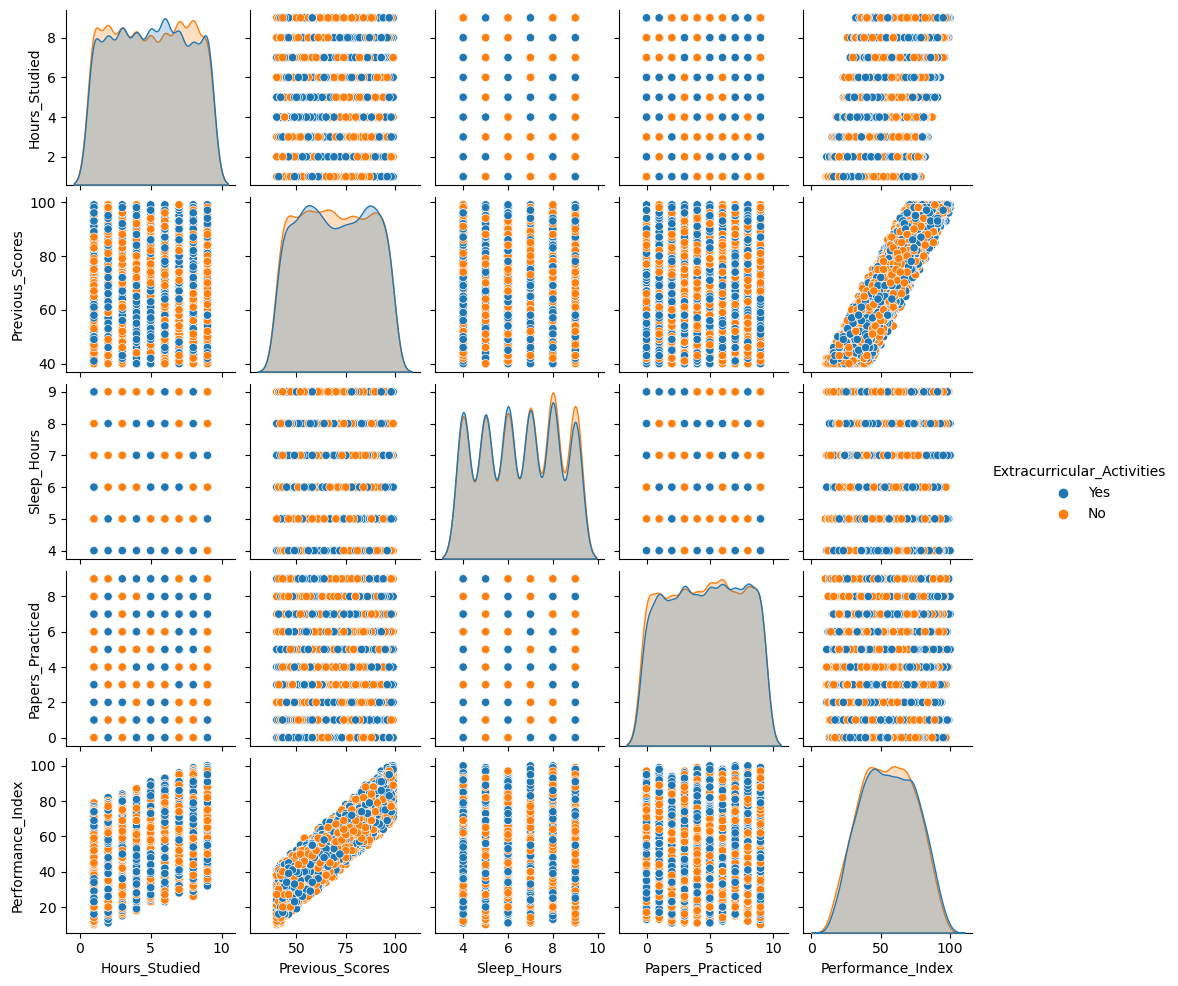

In [251]:
sns.pairplot(data = dataset, hue = "Extracurricular_Activities", height=2)
plt.show()

H0 : The average Performance Index of students who participate in Extracurricular Activities = students who do not participate.
H1 : The average Performance Index of students who participate in Extracurricular Activities > students who do not participate.

In [252]:
significance_level = 0.05

In [253]:
data_extracurricular = dataset[dataset["Extracurricular_Activities"]=="Yes"]["Performance_Index"].values

data_not_extracurricular = dataset[dataset["Extracurricular_Activities"]=="No"]["Performance_Index"].values


np.var(data_extracurricular), np.var(data_not_extracurricular)

(370.874513922569, 366.5309625072948)

In [257]:
from scipy import stats
pvalue = stats.ttest_ind(a = data_extracurricular, 
                         b = data_not_extracurricular, 
                         equal_var=False, 
                         alternative = "greater")

print(f'p-value = {result.pvalue}\n')

if result.pvalue < significance_level:
    print(f'If the p-value {result.pvalue} is less than 0.05, then reject the null hypothesis')
else:
    print(f'If the p-value {result.pvalue} is greater than 0.05, then failed to reject the Null hypothesis')


p-value = 0.004787545663371792

If the p-value 0.004787545663371792 is less than 0.05, then reject the null hypothesis


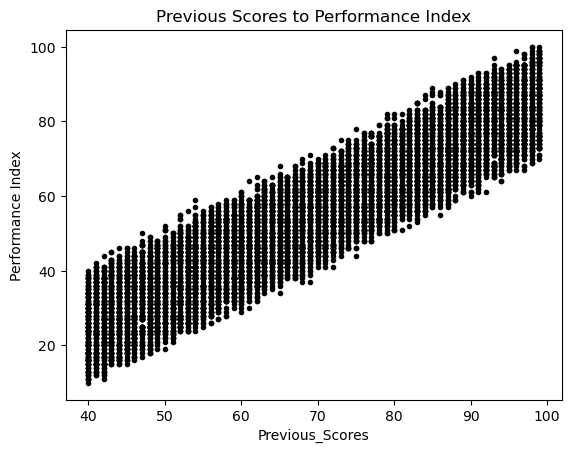

In [270]:
# Regression model using Previous_Scores and Performance_Index variables

x = dataset["Previous_Scores"]
y = dataset["Performance_Index"]

# Plot the data
plt.scatter(x, y, color = "k", marker=".")

# Add a legend and labels
plt.xlabel("Previous_Scores")
plt.ylabel("Performance Index")

# Add a title and adjust the margins
plt.title("Previous Scores to Performance Index")

# Show the plot
plt.show()

In [201]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from statsmodel
    :return df: <pandas DataFrame> combined estimated coefficient and standard error of model estimate
    """
    coef = results.params
    std_err = results.bse
    
    df = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df

In [218]:
# Create OLS model object
model = smf.ols("Performance_Index ~ Previous_Scores", dataset)

# Fit the model
results_model = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_1 = print_coef_std_err(results_model)
results_1


,coef,std err
Intercept,-15.237815,0.321972
Previous_Scores,1.014593,0.004499


In [216]:
print(f'r-squared = {results_model.rsquared}')

r-squared = 0.8374722131868853


Performance_Index = -15.237815 + 1.014593 × Previous_Scores

The variable that have highest relation to performance index is previous scores.
The expected performance index of student who don't have previous scores is -15.237815.
Comparing student that have previous scores, each increase of 1 unit in the previous score will increase the performance index value by 1.014593.

The model explained 83.7% of variance of performance index. After observing the data, a decrease in the performance index value from the previous score was noticed. This leads us to assume that this decline is responsible for making the intercept value negative.

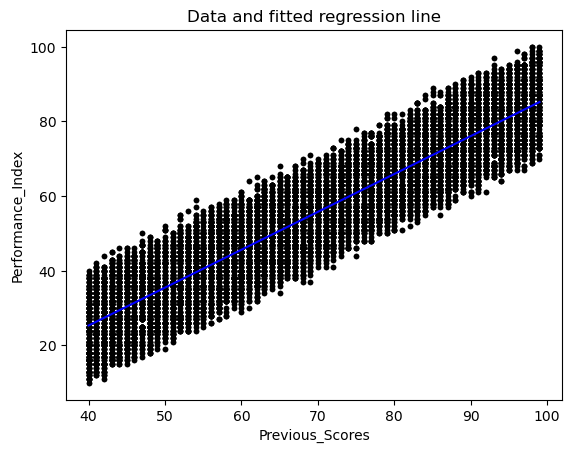

In [220]:
predictor = "Previous_Scores"
outcome = "Performance_Index"
data = dataset.copy()
results_2 = results_1.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat = results_2.loc["Intercept"]["coef"]
b_hat = results_2.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "b")

# Add a legend and labels
# plt.legend()
plt.ylabel(outcome)
plt.xlabel(predictor)

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

In [277]:
dataset["Extracurricular_Activities"] = dataset["Extracurricular_Activities"].map({"No":0,"Yes":1})
dataset.head()

,Hours_Studied,Previous_Scores,Extracurricular_Activities,Sleep_Hours,Papers_Practiced,Performance_Index
0,7,99,1,9,1,91
1,4,82,0,4,2,65
2,8,51,1,7,2,45
3,5,52,1,5,2,36
4,7,75,0,8,5,66


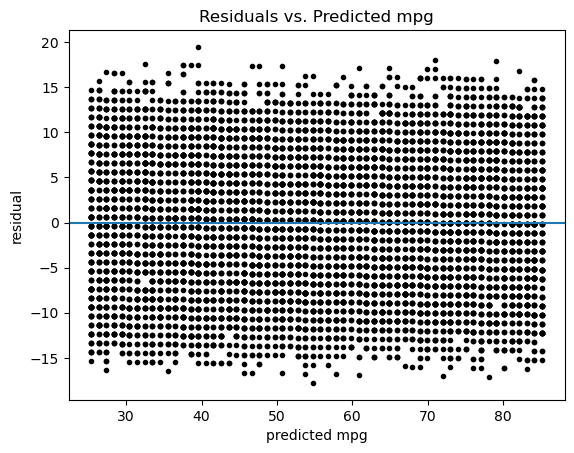

r-squared = 0.8374722131868853


In [225]:
# Regression model using multiple predictors

# Residual Plot and Explained Variance
plt.scatter(results_model.fittedvalues, results_model.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted mpg")
plt.show()

print(f'r-squared = {results_model.rsquared}')

In [226]:
class StatsmodelsRegressor(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    
    def __init__(self, sm_class, sm_formula):
        self.sm_class = sm_class
        self.sm_formula = sm_formula
        self.model = None
        self.result = None
 
    def fit(self, data, dummy):
        self.model = self.sm_class(self.sm_formula, data)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

def kfold_split(data, n_fold):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param data: <pandas DataFrame> 
    :param n_fold: <int> Number of fold in k-fold CV
    :return fold_train: <pandas DataFrame> Training Data
    :return fold_test: <pandas DataFrame> Testing Data
    """
    kfold = KFold(n_splits = n_fold, 
                  shuffle = True, 
                  random_state=123)
    fold_train = {}
    fold_test = {}

    for i, (train, test) in enumerate(kfold.split(data)):
        print(f"fold {i+1}, train data rows: {len(train)}, test data rows: {len(test)}")
        fold_train[i] = data.iloc[train].copy()
        fold_test[i] = data.iloc[test].copy()
        
    return (fold_train, fold_test)

In [232]:
# Create a class model
ols_all_pred = StatsmodelsRegressor(smf.ols, "Performance_Index ~ Hours_Studied + Previous_Scores + C(Extracurricular_Activities) + Sleep_Hours")

# Create k-fold splitter object
kfold = KFold(n_splits=5, shuffle = True, random_state=123)

scores_ols_all_pred = cross_val_score(estimator = ols_all_pred,
                                       X = dataset,
                                       y = dataset["Performance_Index"],
                                       cv = kfold,
                                       scoring = "r2")
scores_ols_all_pred = pd.DataFrame(data = scores_ols_all_pred, 
                                    columns=["test_rsquared"])
scores_ols_all_pred["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_all_pred

,test_rsquared,folds
0,0.988105,Folds 1
1,0.988158,Folds 2
2,0.987255,Folds 3
3,0.987688,Folds 4
4,0.987861,Folds 5


In [228]:
scores_ols_all_pred["test_rsquared"].mean()

0.9878134870121024

In [233]:
# Create OLS model object
model = smf.ols("Performance_Index ~ Hours_Studied + Previous_Scores + C(Extracurricular_Activities) + Sleep_Hours", dataset)

# Fit the model
results_model = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results = print_coef_std_err(results_model)
results

,coef,std err
Intercept,-33.235116,0.128878
C(Extracurricular_Activities)[T.1],0.632041,0.042654
Hours_Studied,2.856112,0.008235
Previous_Scores,1.018599,0.001231
Sleep_Hours,0.482003,0.012562


Performance_Index for not participate in Extracurricular Activities  = -33.235116 + 2.856112 × Hours_Studied + 1.018599 x Previous_Scores + 0.482003 x Sleep_Hours

Performance_Index for participate in Extracurricular Activities = -33.235116 + 0.632041 x Extracurricular_Activities + 2.856112 × Hours_Studied + 1.018599 x Previous_Scores + 0.482003 x Sleep_Hours

Based on model, the average of student's performance index who participate in achieve Extracurricular Activities is higher 0.632041 than student who do not participate in achieve Extracurricular Activities.


After observing the model, a decrease in the performance index value from the previous score was noticed. This leads us to assume that this decline is responsible for making the intercept value negative.

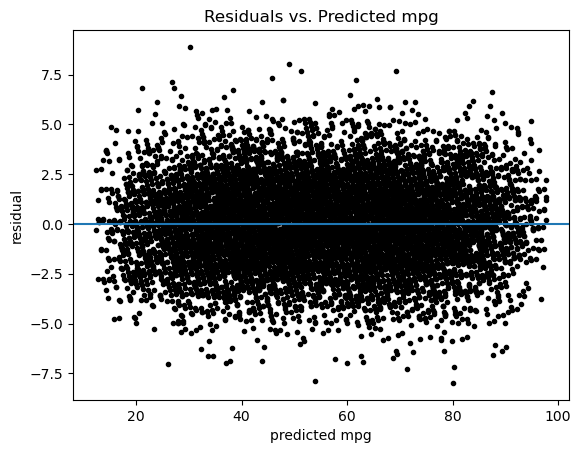

r-squared = 0.9878440597259003


In [235]:
# Residual Plot and Explained Variance
plt.scatter(results_model.fittedvalues, results_model.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted mpg")
plt.show()

print(f'r-squared = {results_model.rsquared}')

The performance of the model is good, The model explained 98.78% of variance of performance index

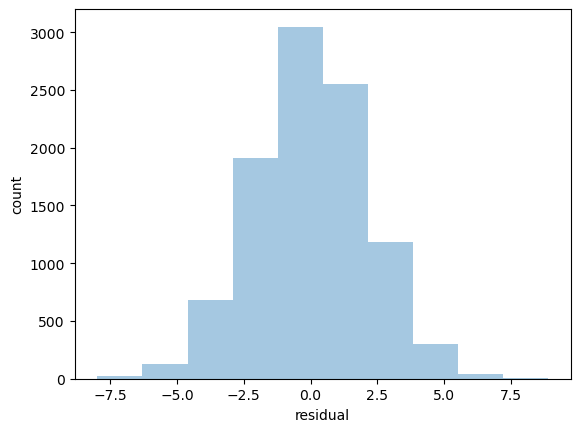

In [237]:
# Normality of Error Assumption

plt.hist(results_model.resid, color='tab:blue', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")

plt.show()